# Helpful references:

Model structure: https://www.tensorflow.org/text/tutorials/text_classification_rnn

Project structure: https://github.com/The-AI-Summer/Deep-Learning-In-Production/tree/master/2.%20Writing%20Deep%20Learning%20code:%20Best%20Practises

Transforming Categorical Data: https://developers.google.com/machine-learning/data-prep/transform/transform-categorical

# Install and import the necessary dependencies

In [ ]:

from google.colab import drive

#This will prompt for authorization.
drive.mount('/content/drive')

#Create a symbolic link, in order no to be able to save weights on drive. 
!ln -s /content/drive/My\ Drive /content/mydrive


#Install requirements
%cd mydrive/SentimentAnalysis
!pip install -r requirements.txt 

import os
import sys
import pandas as pd

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/utils')
import Config, visualization

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/data')
import dataloader, datacleaner

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/models/')
import BaseModel,LSTM

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/configs')
import config_main


Mounted at /content/drive
/content/drive/My Drive/SentimentAnalysis
     |████████████████████████████████| 541 kB 9.6 MB/s 
     |████████████████████████████████| 168 kB 67.1 MB/s 
     |████████████████████████████████| 106 kB 55.9 MB/s 
     |████████████████████████████████| 287 kB 47.9 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=b57d3c925ff19f3a290b0397bb3dc64c9496e25a2fb975bf356afafa4a16d344
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=100bce2d782b4792289b9f94d4c9161d781c4b9066177a0edb2b413567eb77b7
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=dc8f806e25a332b29b2014b4641f542992a6d31ea798d4b7039673e9ade51d17
  Stored in directory: /root/.cache/pi

# Load data

In [ ]:
input_path = os.path.join(config_main.CFG['data']['base_path'], 
                          config_main.CFG['data']['name'])

#Download and unzip dataset
if not (os.path.isfile(config_main.CFG['data']['url'].split('/')[-1])):
  dataloader.download_dataset_from_url(config_main.CFG['data']['url'])
dataloader.unzip_data_to_folder(input_path, config_main.CFG['data']['url'].split('/')[-1])

#Read unzipped data
print("Reading training data...")
train_data_df = pd.read_csv(os.path.join(input_path, 'training.1600000.processed.noemoticon.csv'),  
                            encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

print("Reading testing data...")
test_data_df = pd.read_csv(os.path.join(input_path, 'testdata.manual.2009.06.14.csv'),  
                           encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

#Print dataset info
print(train_data_df.info())


Directory already existed :  /content/mydrive/SentimentAnalysis/datasets/Sentiment140
Reading training data...
Reading testing data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   tweet      1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


# Preprocess data

In [ ]:
# Preprocessing tweets data
print("Cleaning and parsing the tweets from training data...")
# train_data_df = train_data_df.iloc[500000:1000000] #Uncomment to train on a smaller dataset
train_data_df.tweet = train_data_df.tweet.apply(datacleaner.preprocess_tweet)
print("Finished!\n")

# Preprocessing labels to have classes 0 and 1
train_data_df.sentiment = train_data_df.sentiment.apply(lambda value: 1 if value==4 
                                                        else value)

print("Sentiment values: ")
print(train_data_df.sentiment.value_counts())

print(train_data_df.head(5))


# Preprocessing tweets data
print("\nCleaning and parsing the tweets from testing data...")
# test_data_df = test_data_df.iloc[0:5000] #Uncomment to test on a smaller dataset
test_data_df.tweet = test_data_df.tweet.apply(datacleaner.preprocess_tweet)
print("Finished!\n")

test_data_df = test_data_df[test_data_df.sentiment!=2] #Remove intermediate polarities
test_data_df.sentiment.value_counts()/test_data_df.shape[0]

test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)

print(test_data_df.sentiment.value_counts()/test_data_df.shape[0])


# Preprocessing labels to have classes 0 and 1
test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)


Cleaning and parsing the tweets from training data...
Finished!

Sentiment values: 
0    800000
1    800000
Name: sentiment, dtype: int64
   sentiment                                              tweet
0          0  that is bummer you should got david carr of th...
1          0  is upset that he cannot update his facebook by...
2          0  dived many times for the ball managed to save ...
3          0     my whole body feels itchy and like its on fire
4          0  no it is not behaving at all am mad why am her...

Cleaning and parsing the tweets from testing data...
Finished!

1    0.506964
0    0.493036
Name: sentiment, dtype: float64


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Analyze data
Estimating the vocabulary size and the vector sequence length to be fed to the model every instance is a crucial step for a good model.

This is achieved by analyzing the training dataset, by plotting the 
distribution of tweet lengths across the training data.

The label distribution is also visualized to check whether the training dataset is imbalanced.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Total Unique Words: 77635
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Total words 19845610
Total stop words 8547607
Ratio of total words to total stop words: 2.321773801720177


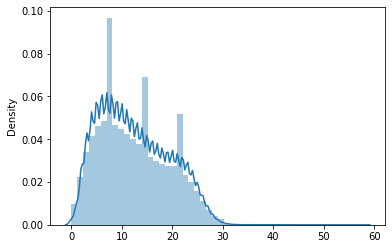

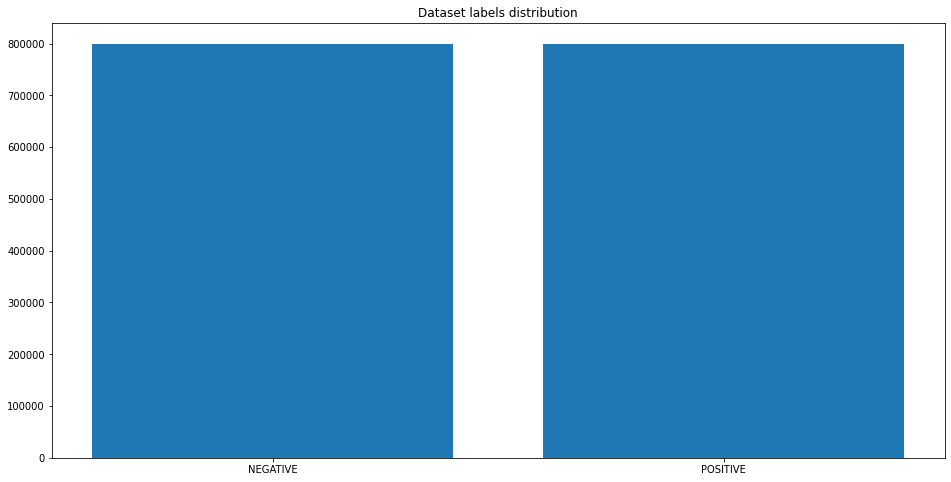

In [ ]:
visualization.visualize_tweet_length(train_data_df)
visualization.visualize_label_distribution(train_data_df)


# Train, save/serialize and evaluate the model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 40)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 40, 64)            4525056   
                                                                 
 dropout_2 (Dropout)         (None, 40, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


1250/1250 [==============================] - 612s 486ms/step - loss: 0.5258 - accuracy: 0.7567 - val_loss: 0.6309 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 0.5125 - accuracy: 0.7645INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


1250/1250 [==============================] - 609s 487ms/step - loss: 0.5125 - accuracy: 0.7645 - val_loss: 0.4541 - val_accuracy: 0.7968 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 608s 487ms/step - loss: 0.5152 - accuracy: 0.7572 - val_loss: 0.4653 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.7597INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


1250/1250 [==============================] - 626s 501ms/step - loss: 0.5110 - accuracy: 0.7597 - val_loss: 0.4498 - val_accuracy: 0.8009 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 615s 492ms/step - loss: 0.4769 - accuracy: 0.7890 - val_loss: 0.4529 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 6/20
1250/1250 [==============================] - 616s 493ms/step - loss: 0.4586 - accuracy: 0.8004 - val_loss: 0.4501 - val_accuracy: 0.8054 - lr: 0.0010
Epoch 7/20
1250/1250 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.7961INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


1250/1250 [==============================] - 628s 502ms/step - loss: 0.4589 - accuracy: 0.7961 - val_loss: 0.4398 - val_accuracy: 0.8055 - lr: 0.0010
Epoch 8/20
1250/1250 [==============================] - 616s 493ms/step - loss: 0.4467 - accuracy: 0.8074 - val_loss: 0.4488 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 9/20
1250/1250 [==============================] - 616s 493ms/step - loss: 0.4532 - accuracy: 0.8018 - val_loss: 0.4415 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 10/20
1250/1250 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8030INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


1250/1250 [==============================] - 627s 501ms/step - loss: 0.4532 - accuracy: 0.8030 - val_loss: 0.4394 - val_accuracy: 0.8064 - lr: 0.0010
Epoch 11/20
1250/1250 [==============================] - ETA: 0s - loss: 0.4398 - accuracy: 0.8106INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


1250/1250 [==============================] - 626s 500ms/step - loss: 0.4398 - accuracy: 0.8106 - val_loss: 0.4336 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 12/20
1250/1250 [==============================] - 617s 494ms/step - loss: 0.4394 - accuracy: 0.8130 - val_loss: 0.4336 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 13/20
1250/1250 [==============================] - 617s 493ms/step - loss: 0.4273 - accuracy: 0.8220 - val_loss: 0.4389 - val_accuracy: 0.8116 - lr: 0.0010
Epoch 14/20
1250/1250 [==============================] - 603s 482ms/step - loss: 0.4402 - accuracy: 0.8140 - val_loss: 0.4393 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 15/20
1250/1250 [==============================] - 596s 477ms/step - loss: 0.4331 - accuracy: 0.8163 - val_loss: 0.4374 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 16/20
1250/1250 [==============================] - 596s 477ms/step - loss: 0.4183 - accuracy: 0.8290 - val_loss: 0.4424 - val_accuracy: 0.8132 - lr: 0.0010
Plotting the loss and accuracy graphs...

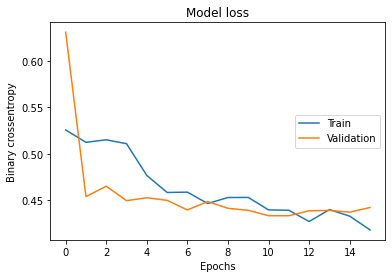

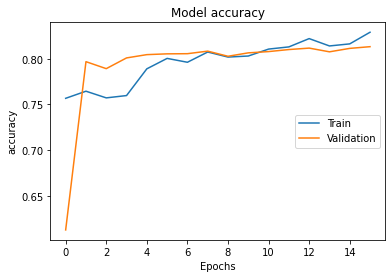

export_path = /content/mydrive/SentimentAnalysis/models/lstm_model_75000_40_2

INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/lstm_model_75000_40_2/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/lstm_model_75000_40_2/assets


2/2 [==============================] - 1s 26ms/step - loss: 0.3891 - accuracy: 0.8281


In [ ]:
model = LSTM.LSTM(config_main.CFG)
model.create_train_pipeline(train_data_df)

model.data_vectorization(config_main.CFG['model']['data_vectorization']['max_features'], 
                         config_main.CFG['model']['data_vectorization']['max_len'])
model.build_model()
model.train()

model.create_test_pipeline(test_data_df)
model.test()

# Conclusions: 

The model has a good accuracy of ~82.81% when testing on the two classes.

The accuracy could be further improved by fine-tuning the model's hyperparameters,
such as the number of layers, number of units per layer, dropout,
learning rate, etc. A good choice for this purpose would be the use of Keras tuner: 
https://www.tensorflow.org/tutorials/keras/keras_tuner

Different architectures could also be tested, that may prove more effective,
such as BERT:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert